In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = 12, 18

# What is Camera Calibration?
Geometric camera calibration, also referred to as camera resectioning, estimates the parameters of a lens and image sensor of an image or video camera. You can use these parameters to correct for lens distortion, measure the size of an object in world units, or determine the location of the camera in the scene. These tasks are used in applications such as machine vision to detect and measure objects. They are also used in robotics, for navigation systems, and 3-D scene reconstruction.

### Camera Calibration Parameters
The calibration algorithm calculates the camera matrix using the extrinsic and intrinsic parameters. The extrinsic parameters represent a rigid transformation from 3-D world coordinate system to the 3-D camera’s coordinate system. The intrinsic parameters represent a projective transformation from the 3-D camera’s coordinates into the 2-D image coordinates.
#### Extrinsic Parameters
The extrinsic parameters consist of a rotation, *R*, and a translation, *t*. The origin of the camera’s coordinate system is at its optical center and its x- and y-axis define the image plane.
#### Intrinsic Parameters
The intrinsic parameters include the focal length, the optical center, also known as the principal point, and the skew coefficient. The camera intrinsic matrix is defined as:
$$K = \begin{bmatrix}f_{x} & 0 & 0\\s & f_{y} & 0\\c_{x} & c_{y} & 1\end{bmatrix}$$
Camera matrix, P:
$$P = \begin{bmatrix}R\\t\end{bmatrix}K$$

The camera matrix does not account for lens distortion because an ideal pinhole camera does not have a lens. To accurately represent a real camera, the camera model includes the **radial** and **tangential** lens distortion.

1. Due to radial distortion, straight lines will appear curved. Its effect is more as we move away from the center of image. Radial distortion occurs when light rays bend more near the edges of a lens than they do at its optical center. The smaller the lens, the greater the distortion.
<img src="../resources/radial_dis.png">
$$x_{distorted} = x(1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
$$y_{distorted} = y(1 + k_{1}r^{2} + k_{2}r^{4} + k_{3}r^{6})$$
where x and y are undistorted pixel locations, k1, k2 and k3 are radial distortion coefficients of lens. Typically, two constants(k1 and k2) are enough.
2. Tangential distortion occurs when the lens and the image plane are not parallel. So some areas in image may look nearer than expected.
$$x_{distorted} = x + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$$
$$y_{distorted} = y + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$$

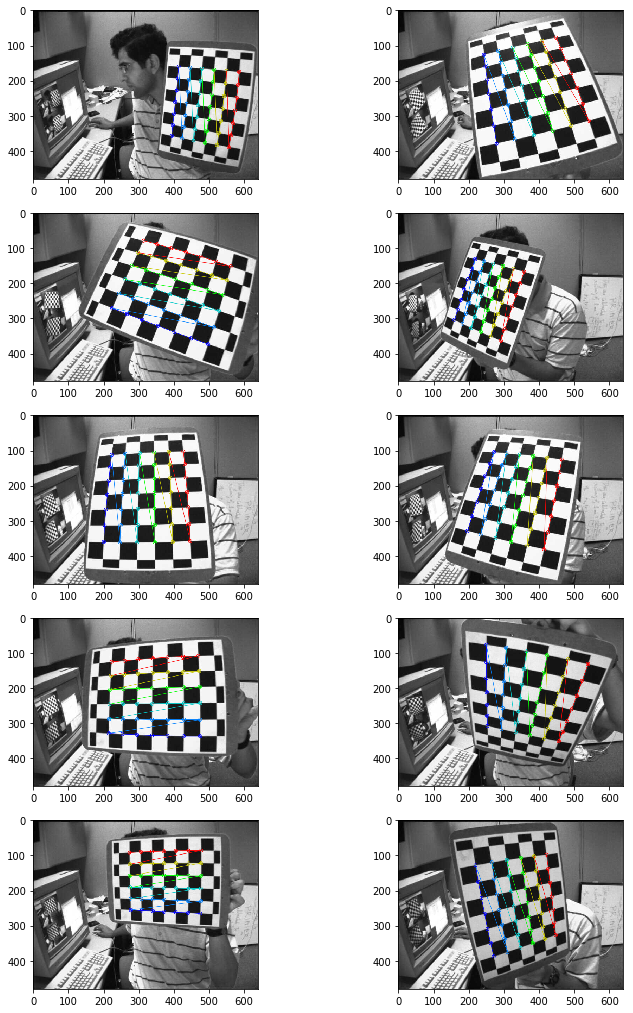

In [2]:
# for calibration, we need atleast 10 test images

import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.

images = glob.glob('../resources/left*.jpg')
outs = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7, 6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11),(-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7, 6), corners2, ret)
        outs.append(img)

total = len(outs)
for i, out in enumerate(outs):
    try:
        plt.subplot(total // 2, 2, i + 1)
        plt.imshow(out)
    except: break

plt.show()

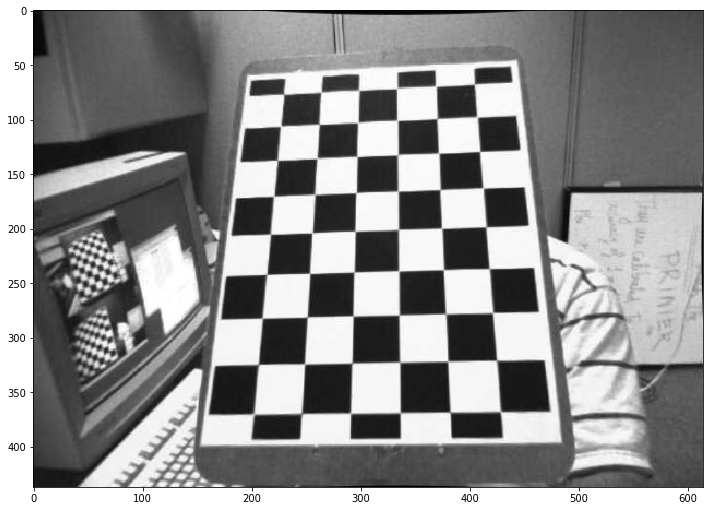

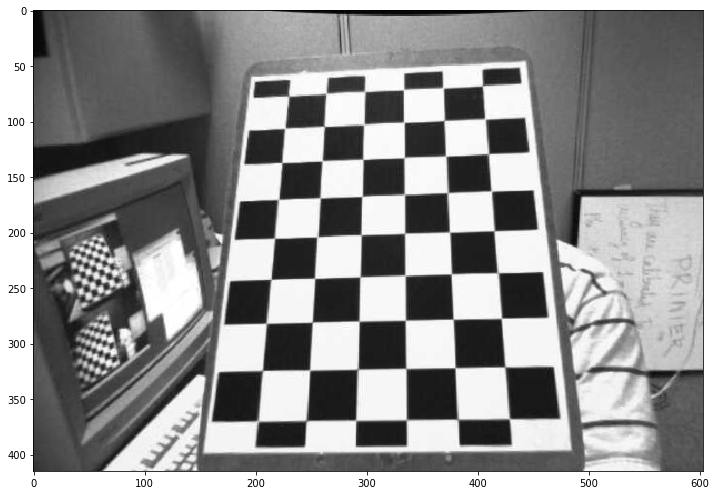

In [3]:
# find camera matrix, distorition coefficients etc
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Now we can undistort our image
img = cv2.imread("../resources/left12.jpg")
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
x, y, w, h = roi

# 2 ways of undistort
# 1. Shortest path undistortion
out1 = cv2.undistort(img, mtx, dist, None, newcameramtx)
out1 = out1[y:y + h, x:x + w]
plt.imshow(out1)
plt.show()

# 2. Curved path, find mapping from distorted to undistorted image
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), 5)
out2 = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
out2 = out2[y:y + h, x:x + w]
plt.imshow(out2)
plt.show()

In [4]:
print(mtx)
print(dist)

[[ 533.92783938    0.          342.3194436 ]
 [   0.          533.91472948  233.46358895]
 [   0.            0.            1.        ]]
[[ -2.94630718e-01   1.11686189e-01   1.55379072e-03  -4.36278860e-05
    4.09936943e-02]]


In [5]:
# Reprojection error to find accuracy of estimated parameters
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print("total error: %.4f %%" % (mean_error / len(objpoints)))

total error: 0.0235 %


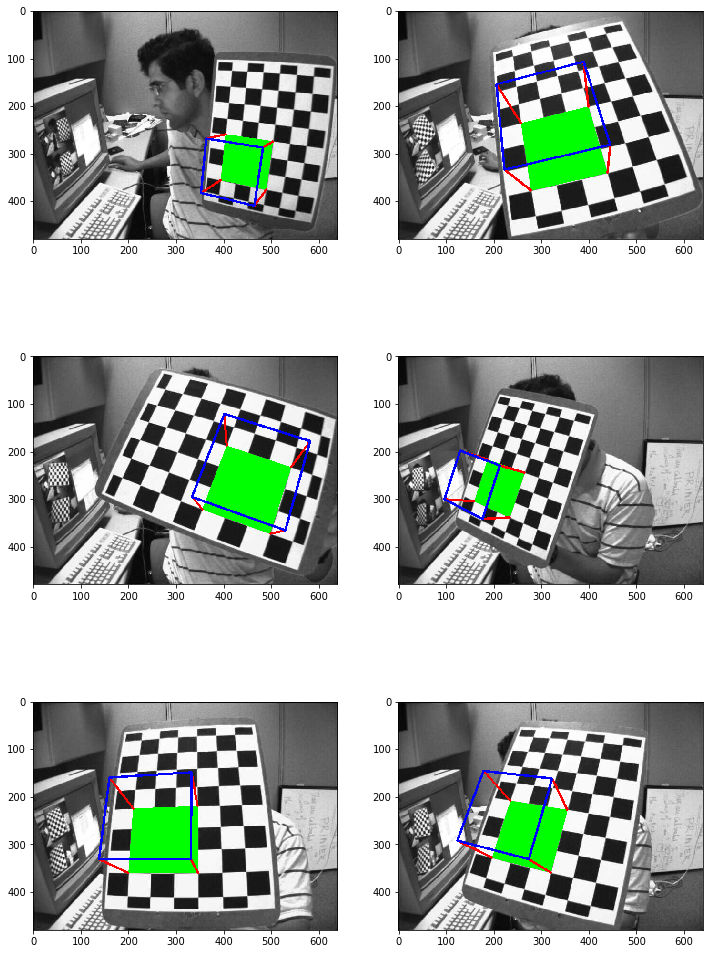

In [6]:
def draw(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1, 2)

    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]], -1, (0, 255, 0), -3)

    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]), (255), 3)

    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]], -1, (0, 0, 255), 3)

    return img

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6 * 7, 1, 3), np.float32)
objp[:, :, :2] = np.mgrid[0:7, 0:6].T.reshape(-1, 1, 2)

axis = np.float32([[0, 0, 0], [0, 3, 0], [3, 3, 0], [3, 0, 0],
                   [0, 0, -3],[0, 3, -3],[3, 3, -3],[3, 0, -3]])

outs = []

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 6),None)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Find the rotation and translation vectors.
        _, rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)
        
        img = draw(img, corners2, imgpts)
        outs.append(img)

for i, out in enumerate(outs):
    try:
        plt.subplot(3, 2, i + 1)
        plt.imshow(out)
    except: break

plt.show()